In [1]:
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from itertools import combinations
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()

C:\Users\Markus\AppData\Local\Temp\ipykernel_22816\3810454438.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/Cleaned_Patents.csv')

In [3]:
#Specifically analyzing bigrams tokens but could be other tokens as well
column = 'BigramsTokens'

In [4]:
df[column] = df[column].str.replace("'null'", "'_null_'", regex=False)
df[column] = df[column].str.replace("'nan'", "'_nan_'", regex=False)

In [5]:
tf_idf_threshold = 0.215
def process_chunk(df_chunk):

    # clean and prepare sentences
    sentences = []
    for text in df_chunk[column]:
        cleaned_text = text.replace('[','').replace(']','').replace(',','').replace("'",'')
        sentences.append(cleaned_text)

    # compute TF-IDF values
    tfidf = TfidfVectorizer()
    x = tfidf.fit_transform(sentences)
    values = x.toarray()
    feature_names = tfidf.get_feature_names_out()
    df_tfidf = pd.DataFrame(values, columns=feature_names)
    
    # Filter based on the tf idf threshold
    filtered_sentences = []
    for i in range(len(df_tfidf)):
        words_above_threshold = df_tfidf.columns[df_tfidf.loc[i] > tf_idf_threshold].tolist()
        filtered_sentences.append(words_above_threshold)

    # add the filtered words back to the temporary DataFrame
    df_chunk = df_chunk.copy()  # Avoids SettingWithCopyWarning
    df_chunk['TF-IDF_Words'] = filtered_sentences

    return df_chunk

In [6]:
df_results = pd.DataFrame()

for year in tqdm(range(1990, 2024)):
    # filter DataFrame for the current year
    df_temp = df[df['PubYear'] == year]
    
    #needed because of memory limitations
    if year >= 2019:
        half_size = len(df_temp) // 2

        df_chunk_1 = df_temp.iloc[:half_size]
        df_results = pd.concat([df_results, process_chunk(df_chunk_1)], axis=0)

        df_chunk_2 = df_temp.iloc[half_size:]
        df_results = pd.concat([df_results, process_chunk(df_chunk_2)], axis=0)
    else:
        df_results = pd.concat([df_results, process_chunk(df_temp)], axis=0)

df_results.reset_index(drop=True, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [02:49<00:00,  5.00s/it]


In [7]:
df_results[column] = df_results[column].progress_apply(literal_eval)

100%|████████████████████████████████████████████████████████████████████████| 578401/578401 [01:21<00:00, 7109.89it/s]


In [8]:
grouped = df_results.groupby(by='PubYear')

In [9]:
#we want to track how many times each keyword occured in each year
yearly_bigram_counts = []
yearly_tf_idf_counts = []

for _, group in tqdm(grouped):
    
    flattened_bigrams = [bigram for sublist in group[column] for bigram in sublist]
    flattened_tfidf = [word for sublist in group['TF-IDF_Words'] for word in sublist]
    
    bigram_count = Counter(flattened_bigrams)
    tfidf_count = Counter(flattened_tfidf)
    
    yearly_bigram_counts.append(bigram_count)
    yearly_tf_idf_counts.append(tfidf_count)

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:07<00:00,  4.53it/s]


In [10]:
years=range(1990,2024)

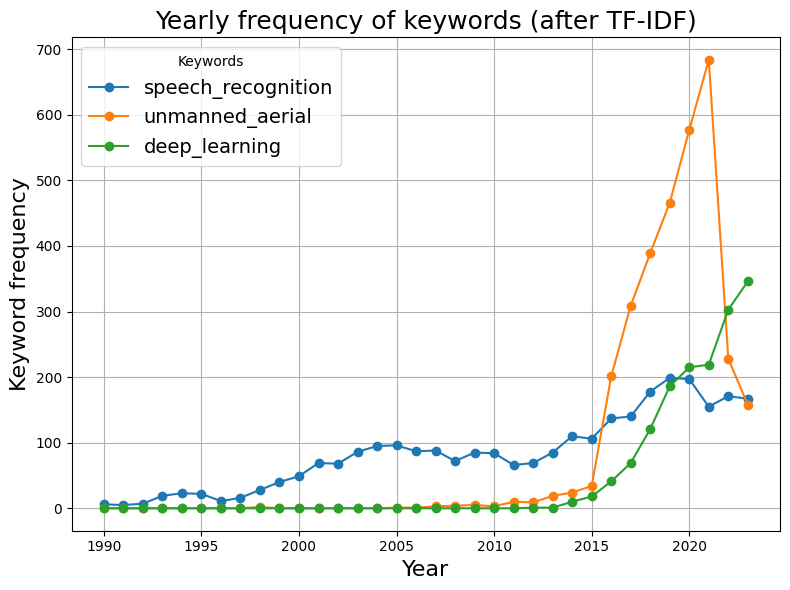

In [11]:
keywords_to_track = ['speech_recognition', 'unmanned_aerial','deep_learning']

fig, ax = plt.subplots(figsize=(8, 6))

for keyword in keywords_to_track:
    counts = [counts.get(keyword, 0) for counts in yearly_tf_idf_counts]
    ax.plot(years, counts, marker='o', label=keyword)
ax.set_title("Yearly frequency of keywords (after TF-IDF)", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Keyword frequency", fontsize=16)
ax.legend(title="Keywords", fontsize=14)
ax.grid(True)

plt.tight_layout()
fig.savefig('visualizations/TF-IDF Graph')
plt.show()

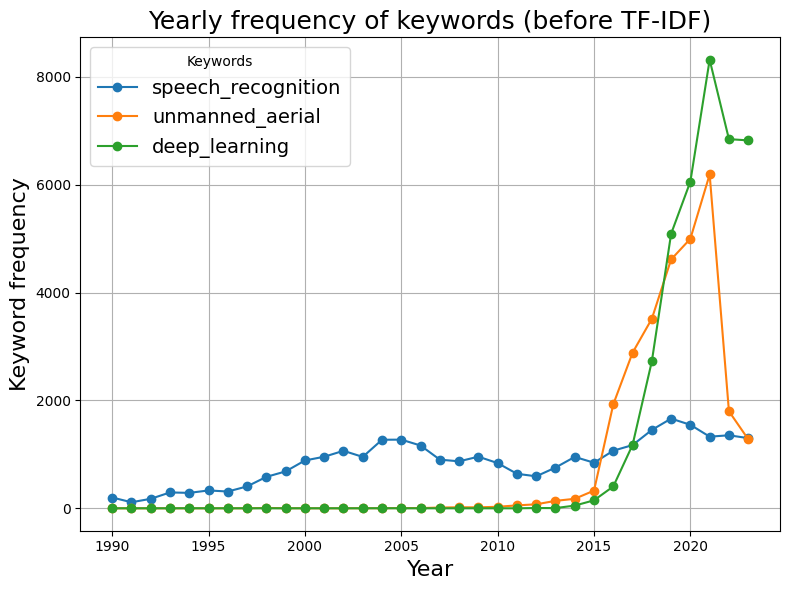

In [12]:
keywords_to_track = ['speech_recognition', 'unmanned_aerial','deep_learning']

fig, ax = plt.subplots(figsize=(8, 6))

for keyword in keywords_to_track:
    counts = [counts.get(keyword, 0) for counts in yearly_bigram_counts]
    ax.plot(years, counts, marker='o', label=keyword)
ax.set_title("Yearly frequency of keywords (before TF-IDF)", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Keyword frequency", fontsize=16)
ax.legend(title="Keywords", fontsize=14)
ax.grid(True)

plt.tight_layout()
fig.savefig('visualizations/Bigram_graph')
plt.show()

In [13]:
df_edges = pd.read_csv('data/edges/tagged_edges.csv')

In [14]:
df_edges_counts = []

df_edges_grouped = df_edges.groupby(by='year')

for year, group in df_edges_grouped:
    all_nodes = group['source'].tolist() + group['target'].tolist()
    counts = Counter(all_nodes)
    df_edges_counts.append(counts)

In [15]:
df_edges_counts[0]['speech_recognition']

3

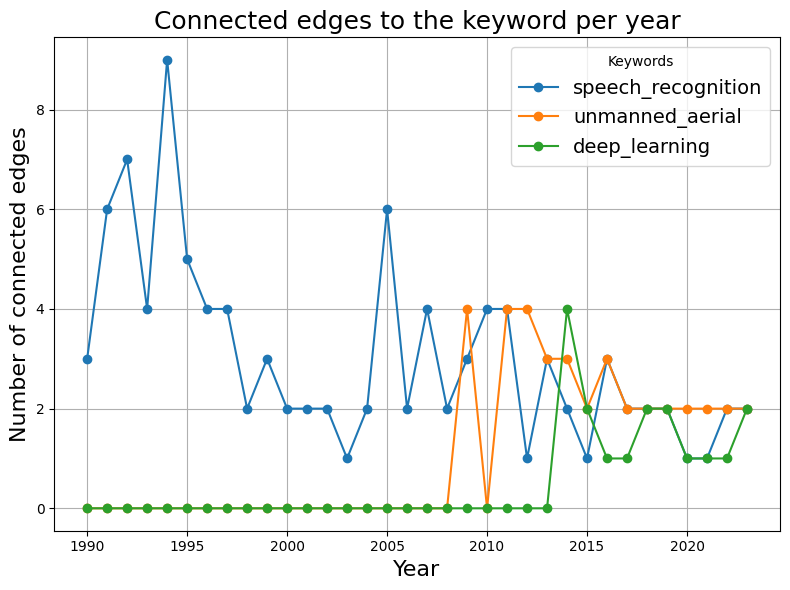

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

for keyword in keywords_to_track:
    counts = [counts.get(keyword, 0) for counts in df_edges_counts]
    ax.plot(years, counts, marker='o', label=keyword)
ax.set_title("Connected edges to the keyword per year", fontsize=18)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Number of connected edges", fontsize=16)
ax.legend(title="Keywords", fontsize=14)
ax.grid(True)

plt.tight_layout()
fig.savefig('visualizations/edges_per_year')
plt.show()

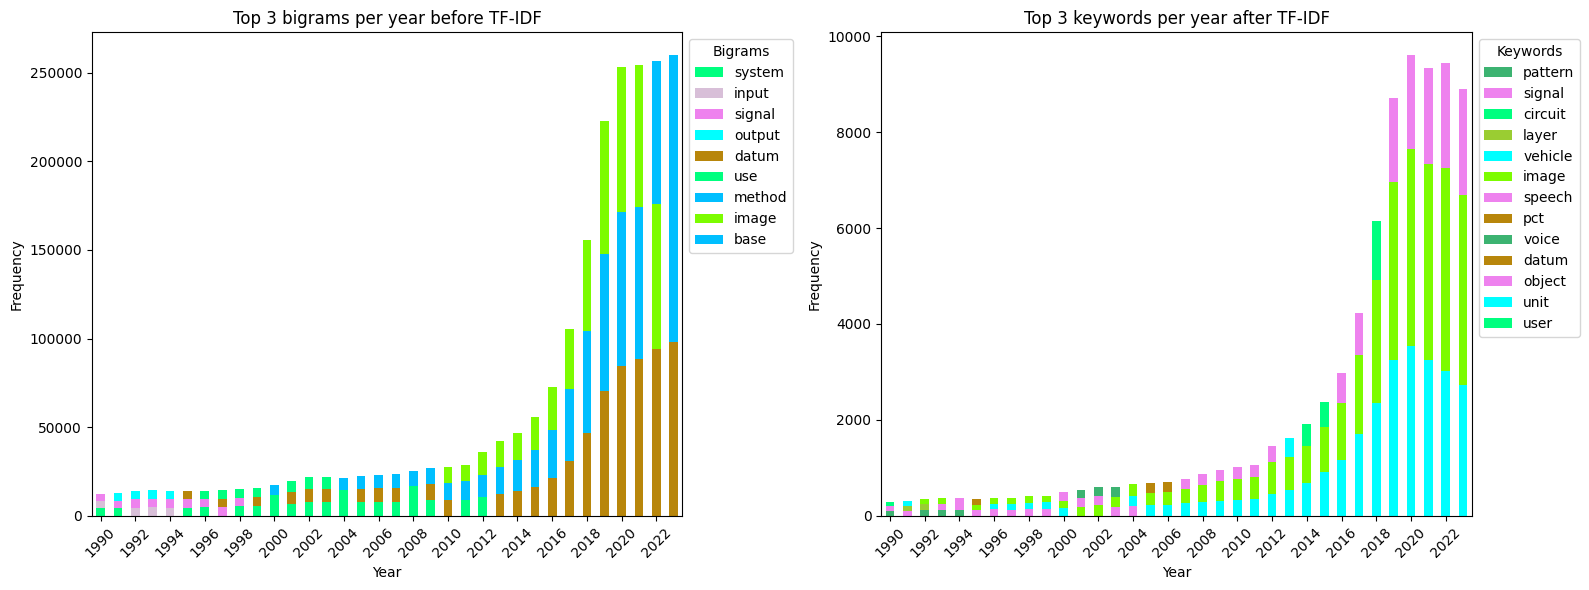

In [28]:
#pick a better coloring scheme
color_mapping = {
    "darkolivegreen": "#556b2f",
    "maroon2": "#7f0000",
    "mediumseagreen": "#3cb371",
    "darkgoldenrod": "#b8860b",
    "darkcyan": "#008b8b",
    "yellowgreen": "#9acd32",
    "indigo": "#4b0082",
    "red": "#ff0000",
    "gold": "#ffd700",
    "lawngreen": "#7cfc00",
    "springgreen": "#00ff7f",
    "royalblue": "#4169e1",
    "aqua": "#00ffff",
    "deepskyblue": "#00bfff",
    "blue": "#0000ff",
    "thistle": "#d8bfd8",
    "coral": "#ff7f50",
    "fuchsia": "#ff00ff",
    "palevioletred": "#db7093",
    "khaki": "#f0e68c",
    "deeppink": "#ff1493",
    "violet": "#ee82ee",
}

# ensure shared color mapping across both histograms 
unique_labels = set()
for counter in yearly_bigram_counts + yearly_tf_idf_counts:
    unique_labels.update(counter.keys())
    
colors = list(color_mapping.values())
label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}


base_year = 1990

baseline_bump = 3000 #used to increase the baseline weight to showcase rise better
top_bigrams_per_year = {}

for i, counter in enumerate(yearly_bigram_counts):
    year = base_year + i
    sorted_bigrams = counter.most_common(3)
    top_bigrams_per_year[year] = {bigram: count + baseline_bump for bigram, count in sorted_bigrams}

df_top_bigrams = pd.DataFrame(top_bigrams_per_year).fillna(0).T


baseline_pump = 50 #used to increase the baseline weight to showcase rise better
top_keywords_per_year = {}

for i, counter in enumerate(yearly_tf_idf_counts):
    year = base_year + i
    sorted_keywords = counter.most_common(3)
    top_keywords_per_year[year] = {keyword: count + baseline_pump for keyword, count in sorted_keywords}

df_top_keywords = pd.DataFrame(top_keywords_per_year).fillna(0).T


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#plot 1: before TF-IDF
df_top_bigrams.plot(
    kind='bar', stacked=True, ax=axes[0], color=[label_to_color[col] for col in df_top_bigrams.columns]
)
axes[0].set_title('Top 3 bigrams per year before TF-IDF')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(range(0, len(years), 2))
axes[0].set_xticklabels(years[::2], rotation=45)
axes[0].legend(title='Bigrams', loc='upper left', bbox_to_anchor=(1, 1))

#plot 2: after TF-IDF
df_top_keywords.plot(
    kind='bar', stacked=True, ax=axes[1], color=[label_to_color[col] for col in df_top_keywords.columns]
)
axes[1].set_title('Top 3 keywords per year after TF-IDF')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(range(0, len(years), 2))
axes[1].set_xticklabels(years[::2], rotation=45)
axes[1].legend(title='Keywords', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('visualizations/top_bigram_tfidf.png', dpi=300)
plt.show()
